In [49]:
!pip install -q datasets torch scikit-learn pandas numpy matplotlib

In [50]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("dariadaria/disneyland_reviews")

print(ds)


DatasetDict({
    train: Dataset({
        features: ['identifier', 'Review_Text', 'topic', 'sentiment'],
        num_rows: 26815
    })
    test: Dataset({
        features: ['identifier', 'Review_Text', 'topic', 'sentiment'],
        num_rows: 8964
    })
})


In [51]:
ds["train"][0]

{'identifier': 448029074,
 'Review_Text': 'Ok, this one will be a short one. You want to visit Disneyland to dream with your kids, right ? Ok then Hong Kong Disney is nothing but the dream.... and why ? Well, the longest queues you will ever stand for, losing your time. Oh and then the dirt on the floor, I will not even go into details, because it is quite disgusting to be honest. The overpopulation in the park and the mass of people make the trip unbareable to be honest. The huge dissappointed and specially when you know Disney Paris, Florida or California... So one good advise. Do not settle for less. Go to the real Disney, dont settle for the mediocre one just because it is nearer......Dont do that to your kids. ',
 'topic': 'weather conditions',
 'sentiment': 2}

In [52]:
df = ds["train"].to_pandas()
df.head()

,identifier,Review_Text,topic,sentiment
0,448029074,"Ok, this one will be a short one. You want to ...",weather conditions,2
1,448029074,"Ok, this one will be a short one. You want to ...",duration of visit,2
2,448029074,"Ok, this one will be a short one. You want to ...",available activities,2
3,448029074,"Ok, this one will be a short one. You want to ...",crowd levels,0
4,448029074,"Ok, this one will be a short one. You want to ...",ride and attraction choices,2


In [53]:
df["sentiment"].value_counts()

,count
sentiment,
2,18330
1,4694
0,3791


In [54]:
df = df[df["sentiment"] != 1]
df["sentiment"] = df["sentiment"].map({0:0, 2:1})
df["sentiment"].value_counts()

,count
sentiment,
1,18330
0,3791


In [55]:
from sklearn.model_selection import train_test_split

X = df["Review_Text"]
y = df["sentiment"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(len(X_train), len(X_val))

17696 4425


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=3,
    ngram_range=(1,2)
)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

print(X_train_vec.shape)

(17696, 10000)


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr = LogisticRegression(class_weight="balanced", max_iter=300)
lr.fit(X_train_vec, y_train)

pred_lr = lr.predict(X_val_vec)

print("=== Logistic Regression baseline ===")
print(classification_report(y_val, pred_lr, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_val, pred_lr))

=== Logistic Regression baseline ===
              precision    recall  f1-score   support

           0      0.197     0.454     0.275       758
           1      0.846     0.618     0.714      3667

    accuracy                          0.590      4425
   macro avg      0.521     0.536     0.494      4425
weighted avg      0.734     0.590     0.639      4425

Confusion matrix:
 [[ 344  414]
 [1401 2266]]


In [58]:
import torch

X_train_t = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
X_val_t = torch.tensor(X_val_vec.toarray(), dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).view(-1,1)

In [59]:
import torch.nn as nn

class TfidfANN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

model = TfidfANN(X_train_t.shape[1])

In [60]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

pos = y_train_t.sum().item()
neg = y_train_t.shape[0] - pos
pos_weight = torch.tensor([neg / pos], dtype=torch.float32)

print("pos_weight =", pos_weight.item())

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(X, y, batch_size=128):
    model.train()
    total_loss = 0.0
    perm = torch.randperm(X.size(0))
    num_batches = 0

    for i in range(0, X.size(0), batch_size):
        idx = perm[i:i+batch_size]
        xb = X[idx]
        yb = y[idx]

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

train_losses = []
val_losses = []

for epoch in range(15):
    train_loss = train_epoch(X_train_t, y_train_t)

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_t)
        val_loss = criterion(val_logits, y_val_t).item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1} | Train: {train_loss:.3f} | Val: {val_loss:.3f}")

pos_weight = 0.2068471610546112
Epoch 1 | Train: 0.238 | Val: 0.237
Epoch 2 | Train: 0.236 | Val: 0.235
Epoch 3 | Train: 0.229 | Val: 0.238
Epoch 4 | Train: 0.222 | Val: 0.244
Epoch 5 | Train: 0.216 | Val: 0.261
Epoch 6 | Train: 0.213 | Val: 0.266
Epoch 7 | Train: 0.210 | Val: 0.266
Epoch 8 | Train: 0.207 | Val: 0.298
Epoch 9 | Train: 0.205 | Val: 0.288
Epoch 10 | Train: 0.204 | Val: 0.300
Epoch 11 | Train: 0.201 | Val: 0.315
Epoch 12 | Train: 0.200 | Val: 0.336
Epoch 13 | Train: 0.198 | Val: 0.353
Epoch 14 | Train: 0.196 | Val: 0.388
Epoch 15 | Train: 0.195 | Val: 0.382


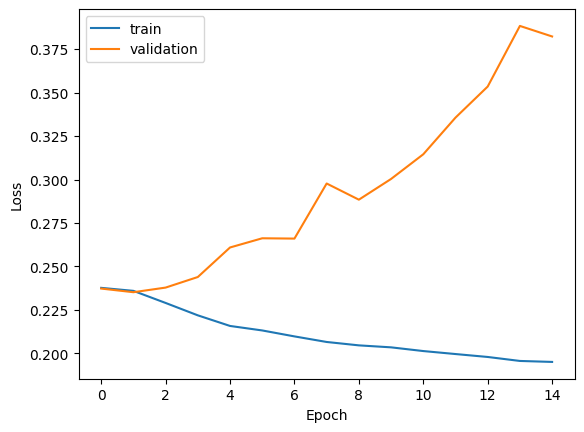

In [61]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [62]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(X_val_t)).numpy().flatten()

pred = (probs > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_val, pred))
print("F1:", f1_score(y_val, pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, pred))
print("\nReport:\n", classification_report(y_val, pred, digits=3))

Accuracy: 0.39299435028248586
F1: 0.4885757806549886
Confusion Matrix:
 [[ 456  302]
 [2384 1283]]

Report:
               precision    recall  f1-score   support

           0      0.161     0.602     0.253       758
           1      0.809     0.350     0.489      3667

    accuracy                          0.393      4425
   macro avg      0.485     0.476     0.371      4425
weighted avg      0.698     0.393     0.448      4425



In [63]:
import numpy as np

errors = np.where(pred != y_val.values)[0][:20]

for i in errors:
    print("TRUE:", y_val.values[i])
    print("PRED:", pred[i])
    print("PROB_POS:", probs[i])
    print("TEXT:", X_val.iloc[i][:300])
    print("-"*50)

TRUE: 1
PRED: 0
PROB_POS: 0.44975552
TEXT: Disneyland Hong Kong is nice to visit with family and kids but doesn't have enough attractions to fill an entire day. Also, there's really nothing for thrillseekers. Even the Grizzly rollercoaster isn't really thrilling. Disney Hong Kong desperately needs some topattractions (Tower of Terror, Rock '
--------------------------------------------------
TRUE: 1
PRED: 0
PROB_POS: 0.44449815
TEXT: Had a nightmare experience when the online booking system issued tickets for the park which my bank had rejected but this wasn   t picked up until at the park gate which caused Disneyland Park for several security people to pay a visit at the gate, it was resolved 10 minutes later but not the best D
--------------------------------------------------
TRUE: 1
PRED: 0
PROB_POS: 0.46237352
TEXT: Rides are pretty much catered to young children, not so much for thrill seekers.If you prefer thrilling rides, you can visit Ocean Park theme park. FYI, I   m a thrill

In [64]:
df["sentiment"].value_counts(normalize=True)

,proportion
sentiment,
1,0.828624
0,0.171376
